In [44]:
import QuickDraw as Data
from torchvision.models import *
import torch
from torch import nn
import os
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt
import random

In [45]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [46]:
model = get_model("efficientnet_v2_s", num_classes=Data.num_classes, dropout=.2)
model.features[0][0] = nn.Conv2d(1, 24, 3, 2, 1, bias=False)
model.to(device)
model.name = "efficientnet_v2_s"
state = torch.load("./models/temp-efficientnet_v2_s-QuickDraw")
model.load_state_dict(state["model"])

<All keys matched successfully>

In [47]:
files = os.listdir("data/QuickDraw/")
files = [file.split(".")[0] for file in files]

In [48]:
def predict(file, model):
    transform = v2.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True)
    ])
    with Image.open(file) as image:
        img_tensor = transform(image)
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
    img_tensor, _ = torch.max(img_tensor, dim=0, keepdim=True)
    plt.subplot(2, 2, 2)
    plt.imshow(img_tensor.squeeze(), cmap="gray")
    img_tensor = img_tensor.unsqueeze(0).to(device)
    plt.axis("off")
    plt.subplot(2, 2, 3)
    plt.imshow(img_tensor.squeeze().to("cpu"), cmap="gray")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)[0, :]
        logits = torch.softmax(logits, 0, None)
        topk = 5
        probs, ys = torch.topk(logits, topk)
        probs = probs
        ys = ys
        for i in range(topk):
            print(f"{files[ys[i].item()]}: {probs[i].item():.4f}")

In [51]:
import QuickDraw as Data
from sklearn.metrics import confusion_matrix
test = Data.test_dataloader(256)
model.eval()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test:
        # Move inputs and labels to the appropriate device (e.g., GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get the predicted labels (assuming the model outputs logits)
        _, predicted = torch.max(outputs, 1)
        
        # Append true and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [66]:
cm = confusion_matrix(y_true, y_pred, normalize="true")

In [52]:
import os
files = os.listdir("data/QuickDraw/")
files = [file.split(".")[0] for file in files]

In [58]:
reverse = {}
for i, file in enumerate(files):
    reverse[file] = i

In [49]:
random.choice(files)

'penguin'

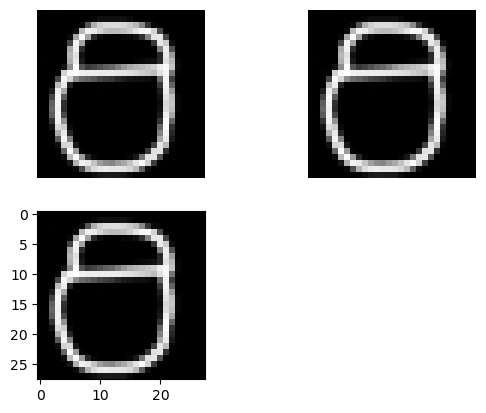

bucket: 0.5005
purse: 0.1290
helmet: 0.1144
basket: 0.1135
paint can: 0.0402


In [50]:
predict("input.jpg", model)

In [71]:
cm[reverse["bucket"]][reverse["helmet"]]

0.009456264775413711